In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage, leaves_list

In [2]:
# PARAMETERS
run_id="group_loops.09.19.ldcts"

In [3]:
# Parameters
run_id = "abc-subclass.12.23.ldcts"


In [4]:
selected_traits = {
    "Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_" : "Alzheimers Disease and Dementia", 
    "Nalls.LancetNeurol.2019.Parkinsons_disease_" : "Parkinson's Disease", 
    "PGC.Nature.2014.Schizophrenia_" : "Schizophrenia", 
    "Wray.biorxiv.2018.Major_Depressive_Disorder_" : "Major Depressive Disorder", 
    "Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_" : "ADHD", 
    "Mullins.NatGenet.2021.Bipolar_Disorder_" : "Bipolar Disorder", 
    "Grove.NatGenet.2019.Autism_Spectrum_Disorder_" : "Autism Spectrum Disorder", 
    "Jansen.2019.NatGenet.Insomnia_" : "Insomnia", 
    "PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_" : "Obsessive Compulsive Disorder", 
    "Deary.MolPsychiatry.2017.Tiredness_" : "Tiredness", 
    "IMSGC.Science.2019.Multiple_sclerosis_" : "Multiple Sclerosis", 
    "Luciano.NatGenet.2017.Neuroticism_" : "Neuroticism", 
    "Okbay.Nature.2016.Educational_Attainment_" : "Educational Attainment", 
    "Palmer.MolPsych.2021.problematic_opioid_use_" : "Problematic Opioid Use", 
    "Savage.NatGenet.2018.Intelligence_" : "Intelligence", 
    "vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_" : "Amyotrophic Lateral Sclerosis", 
    "Barban.NatGenet.2016.Age_First_Birth_" : "Age at First Birth", 
    "Chiou.Nature.2021.Type_1_diabetes_" : "Type 1 Diabetes", 
    "Watson.2018.NatGenet.Anorexia_Nervosa_" : "Anorexia Nervosa"
}

In [5]:
ldsc_results=f'/anvil/projects/x-mcb130189/rwang22/bican/ldsc/output/{run_id}'
directory = Path(ldsc_results)
dfs = {}

for file in directory.glob(f'*.cell_type_results.txt'):
    cur = pd.read_csv(file, sep = "\t")
    stripped = file.stem.replace(f'_.cell_type_results', "")
    cur["Trait"] = stripped
    dfs[stripped] = cur

In [6]:
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df["-log10(pval)"] = -np.log10(combined_df["Coefficient_P_value"])
combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")
combined_df = combined_df[combined_df["Trait"].isin(selected_traits.keys())] # only predetermined selected traits
combined_df.head()

/tmp/ipykernel_3040494/638502812.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  combined_df["Trait"] = combined_df["Trait"].str.replace(f'{run_id}.cell_type_results', "")


,Name,Coefficient,Coefficient_std_error,Coefficient_P_value,Trait,-log10(pval)
480,Lymphocyte,5.609489e-07,1.030976e-07,2.649881e-08,IMSGC.Science.2019.Multiple_sclerosis_,7.576774
481,Microglia,1.958155e-07,7.961951e-08,6.958641e-03,IMSGC.Science.2019.Multiple_sclerosis_,2.157476
482,Astrocyte,2.460399e-08,4.670164e-08,2.991546e-01,IMSGC.Science.2019.Multiple_sclerosis_,0.524104
483,Endo,1.232157e-08,7.402003e-08,4.338964e-01,IMSGC.Science.2019.Multiple_sclerosis_,0.362614
484,Pericyte,1.178201e-08,7.986282e-08,4.413576e-01,IMSGC.Science.2019.Multiple_sclerosis_,0.355209


In [7]:
# Perform FDR correction using Benjamini-Hochberg procedure
rejected, q_values, _, _ = multipletests(combined_df["Coefficient_P_value"], alpha=0.05, method='fdr_bh')
combined_df["FDR_BH_corrected"] = q_values

In [8]:
# calculate the FDR p value threshold 
# https://www.r-bloggers.com/2023/07/the-benjamini-hochberg-procedure-fdr-and-p-value-adjusted-explained/

def fdr_bh_adj(df):
    tmp = combined_df.copy()
    tmp["rank"] =  combined_df['Coefficient_P_value'].rank()
    num_tests = len(tmp)
    tmp["adj_pval"] = (num_tests * tmp["Coefficient_P_value"]) / tmp["rank"]

    return tmp


In [9]:
tmp = fdr_bh_adj(combined_df)
# Align indices before comparison
fdr_bh_corrected = combined_df["FDR_BH_corrected"]
adj_pval = tmp["adj_pval"]

print(fdr_bh_corrected.sort_values())

3210    0.000004
3211    0.000004
1410    0.000004
480     0.000004
1411    0.000006
          ...   
3238    0.999944
3239    0.999944
1049    0.999944
509     0.999944
3479    0.999944
Name: FDR_BH_corrected, Length: 570, dtype: float64


In [10]:
print(adj_pval.sort_values())

1410    0.000004
480     0.000004
3210    0.000004
3211    0.000005
1411    0.000006
          ...   
3474    1.050197
3473    1.051290
2548    1.051486
1673    1.051650
658     1.052761
Name: adj_pval, Length: 570, dtype: float64


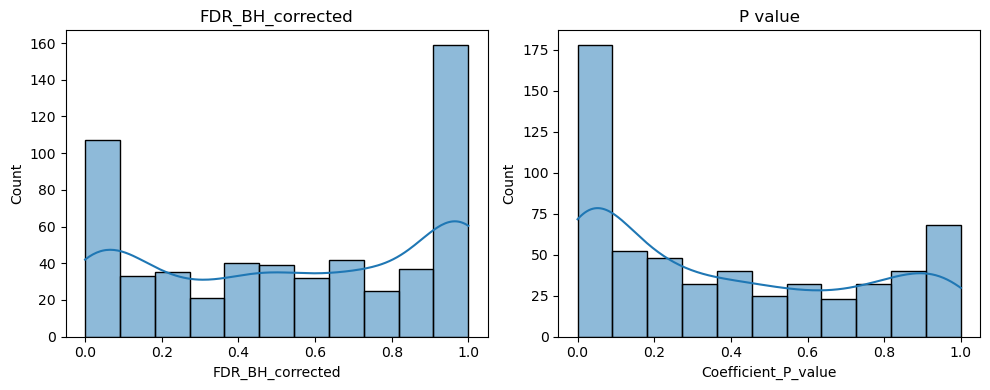

In [11]:
# plot the distribution of p values 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First plot
sns.histplot(combined_df["FDR_BH_corrected"], kde=True, ax=axes[0])
axes[0].set_title("FDR_BH_corrected")

# Second plot
sns.histplot(combined_df["Coefficient_P_value"], kde=True, ax=axes[1])
axes[1].set_title("P value")

plt.tight_layout()
plt.show()

In [12]:
modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', 'FDR_BH_corrected'], axis=1)
modified_df = modified_df.pivot(index="Name", columns="Trait", values="-log10(pval)").reset_index()
modified_df = modified_df.set_index("Name")
modified_df.head()

Trait,Barban.NatGenet.2016.Age_First_Birth_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,Chiou.Nature.2021.Type_1_diabetes_,Deary.MolPsychiatry.2017.Tiredness_,Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_,Grove.NatGenet.2019.Autism_Spectrum_Disorder_,IMSGC.Science.2019.Multiple_sclerosis_,Jansen.2019.NatGenet.Insomnia_,Luciano.NatGenet.2017.Neuroticism_,Mullins.NatGenet.2021.Bipolar_Disorder_,Nalls.LancetNeurol.2019.Parkinsons_disease_,Okbay.Nature.2016.Educational_Attainment_,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_,PGC.Nature.2014.Schizophrenia_,Palmer.MolPsych.2021.problematic_opioid_use_,Savage.NatGenet.2018.Intelligence_,Watson.2018.NatGenet.Anorexia_Nervosa_,Wray.biorxiv.2018.Major_Depressive_Disorder_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_
Name,,,,,,,,,,,,,,,,,,,
Astrocyte,0.586390,1.480209,0.068890,0.660835,1.094975,1.148306,0.524104,0.302752,0.363128,0.166028,1.315843,0.157159,1.230313,0.066497,0.245876,0.375584,0.253447,0.043657,0.069690
CN_Cholinergic_GABA,1.559413,0.025205,0.002320,1.369088,0.416065,0.084168,0.002236,1.293942,1.525071,1.935758,0.362767,0.631617,0.613015,2.749132,0.177481,2.775142,0.398162,0.539306,0.103118
CN_GABA-Glut,0.768702,0.060308,0.116863,1.111575,0.253819,0.806778,0.108524,0.992451,0.583805,0.523362,0.619960,2.004497,0.226154,0.833552,0.268377,1.863493,0.334454,0.833719,0.599290
CN_LAMP5-CXCL14_GABA,0.719575,0.357698,0.066050,0.015258,0.272695,0.173225,0.015479,1.927995,0.885611,5.413267,0.218022,4.067006,0.233353,5.104214,0.351439,5.794510,0.381269,1.701085,0.510843
CN_LAMP5-LHX6_GABA,0.337487,0.197550,0.062522,0.052007,0.290993,0.201760,0.054076,0.561300,0.433896,2.898872,0.159603,3.680261,0.282931,2.308376,0.742047,5.015522,0.873470,1.124694,0.105601


In [13]:
fdr_modified_df = combined_df.drop(['Coefficient', 'Coefficient_std_error', 'Coefficient_P_value', '-log10(pval)'], axis=1)
fdr_modified_df = fdr_modified_df.pivot(index="Name", columns="Trait", values="FDR_BH_corrected").reset_index()
fdr_modified_df = fdr_modified_df.set_index("Name")
fdr_modified_df.head()

Trait,Barban.NatGenet.2016.Age_First_Birth_,Bellenguez.NatGenet.2022.Alzheimers_Disease_Dementia_,Chiou.Nature.2021.Type_1_diabetes_,Deary.MolPsychiatry.2017.Tiredness_,Demontis.NatGenet.2019.Attention_Deficit_Hyperactivity_Disorder_,Grove.NatGenet.2019.Autism_Spectrum_Disorder_,IMSGC.Science.2019.Multiple_sclerosis_,Jansen.2019.NatGenet.Insomnia_,Luciano.NatGenet.2017.Neuroticism_,Mullins.NatGenet.2021.Bipolar_Disorder_,Nalls.LancetNeurol.2019.Parkinsons_disease_,Okbay.Nature.2016.Educational_Attainment_,PGC.MolPsychiatry.2017.Obsessive_Compulsive_Disorder_,PGC.Nature.2014.Schizophrenia_,Palmer.MolPsych.2021.problematic_opioid_use_,Savage.NatGenet.2018.Intelligence_,Watson.2018.NatGenet.Anorexia_Nervosa_,Wray.biorxiv.2018.Major_Depressive_Disorder_,vanRheenen.NatGenet.2016.Amyotrophic_Lateral_Sclerosis_
Name,,,,,,,,,,,,,,,,,,,
Astrocyte,0.539181,0.145118,0.999944,0.493901,0.264761,0.243983,0.586976,0.777732,0.716872,0.929908,0.188660,0.938374,0.212278,0.999944,0.839849,0.714590,0.832462,0.999944,0.999944
CN_Cholinergic_GABA,0.126777,0.999944,0.999944,0.174044,0.689843,0.999944,0.999944,0.193126,0.135031,0.071893,0.716872,0.508109,0.520413,0.015367,0.916638,0.014947,0.701799,0.577729,0.985807
CN_GABA-Glut,0.433704,0.999944,0.980360,0.257444,0.832462,0.411759,0.982227,0.315214,0.540427,0.586976,0.517314,0.064105,0.857282,0.396314,0.819344,0.078840,0.747560,0.396314,0.529195
CN_LAMP5-CXCL14_GABA,0.456329,0.720854,0.999944,0.999944,0.815465,0.919111,0.999944,0.071893,0.372734,0.000122,0.862424,0.001576,0.853999,0.000214,0.727127,0.000061,0.712401,0.101291,0.600018
CN_LAMP5-LHX6_GABA,0.744821,0.888650,0.999944,0.999944,0.793051,0.886611,0.999944,0.559006,0.670554,0.011794,0.937114,0.003217,0.805056,0.037868,0.448628,0.000250,0.372734,0.251612,0.984876


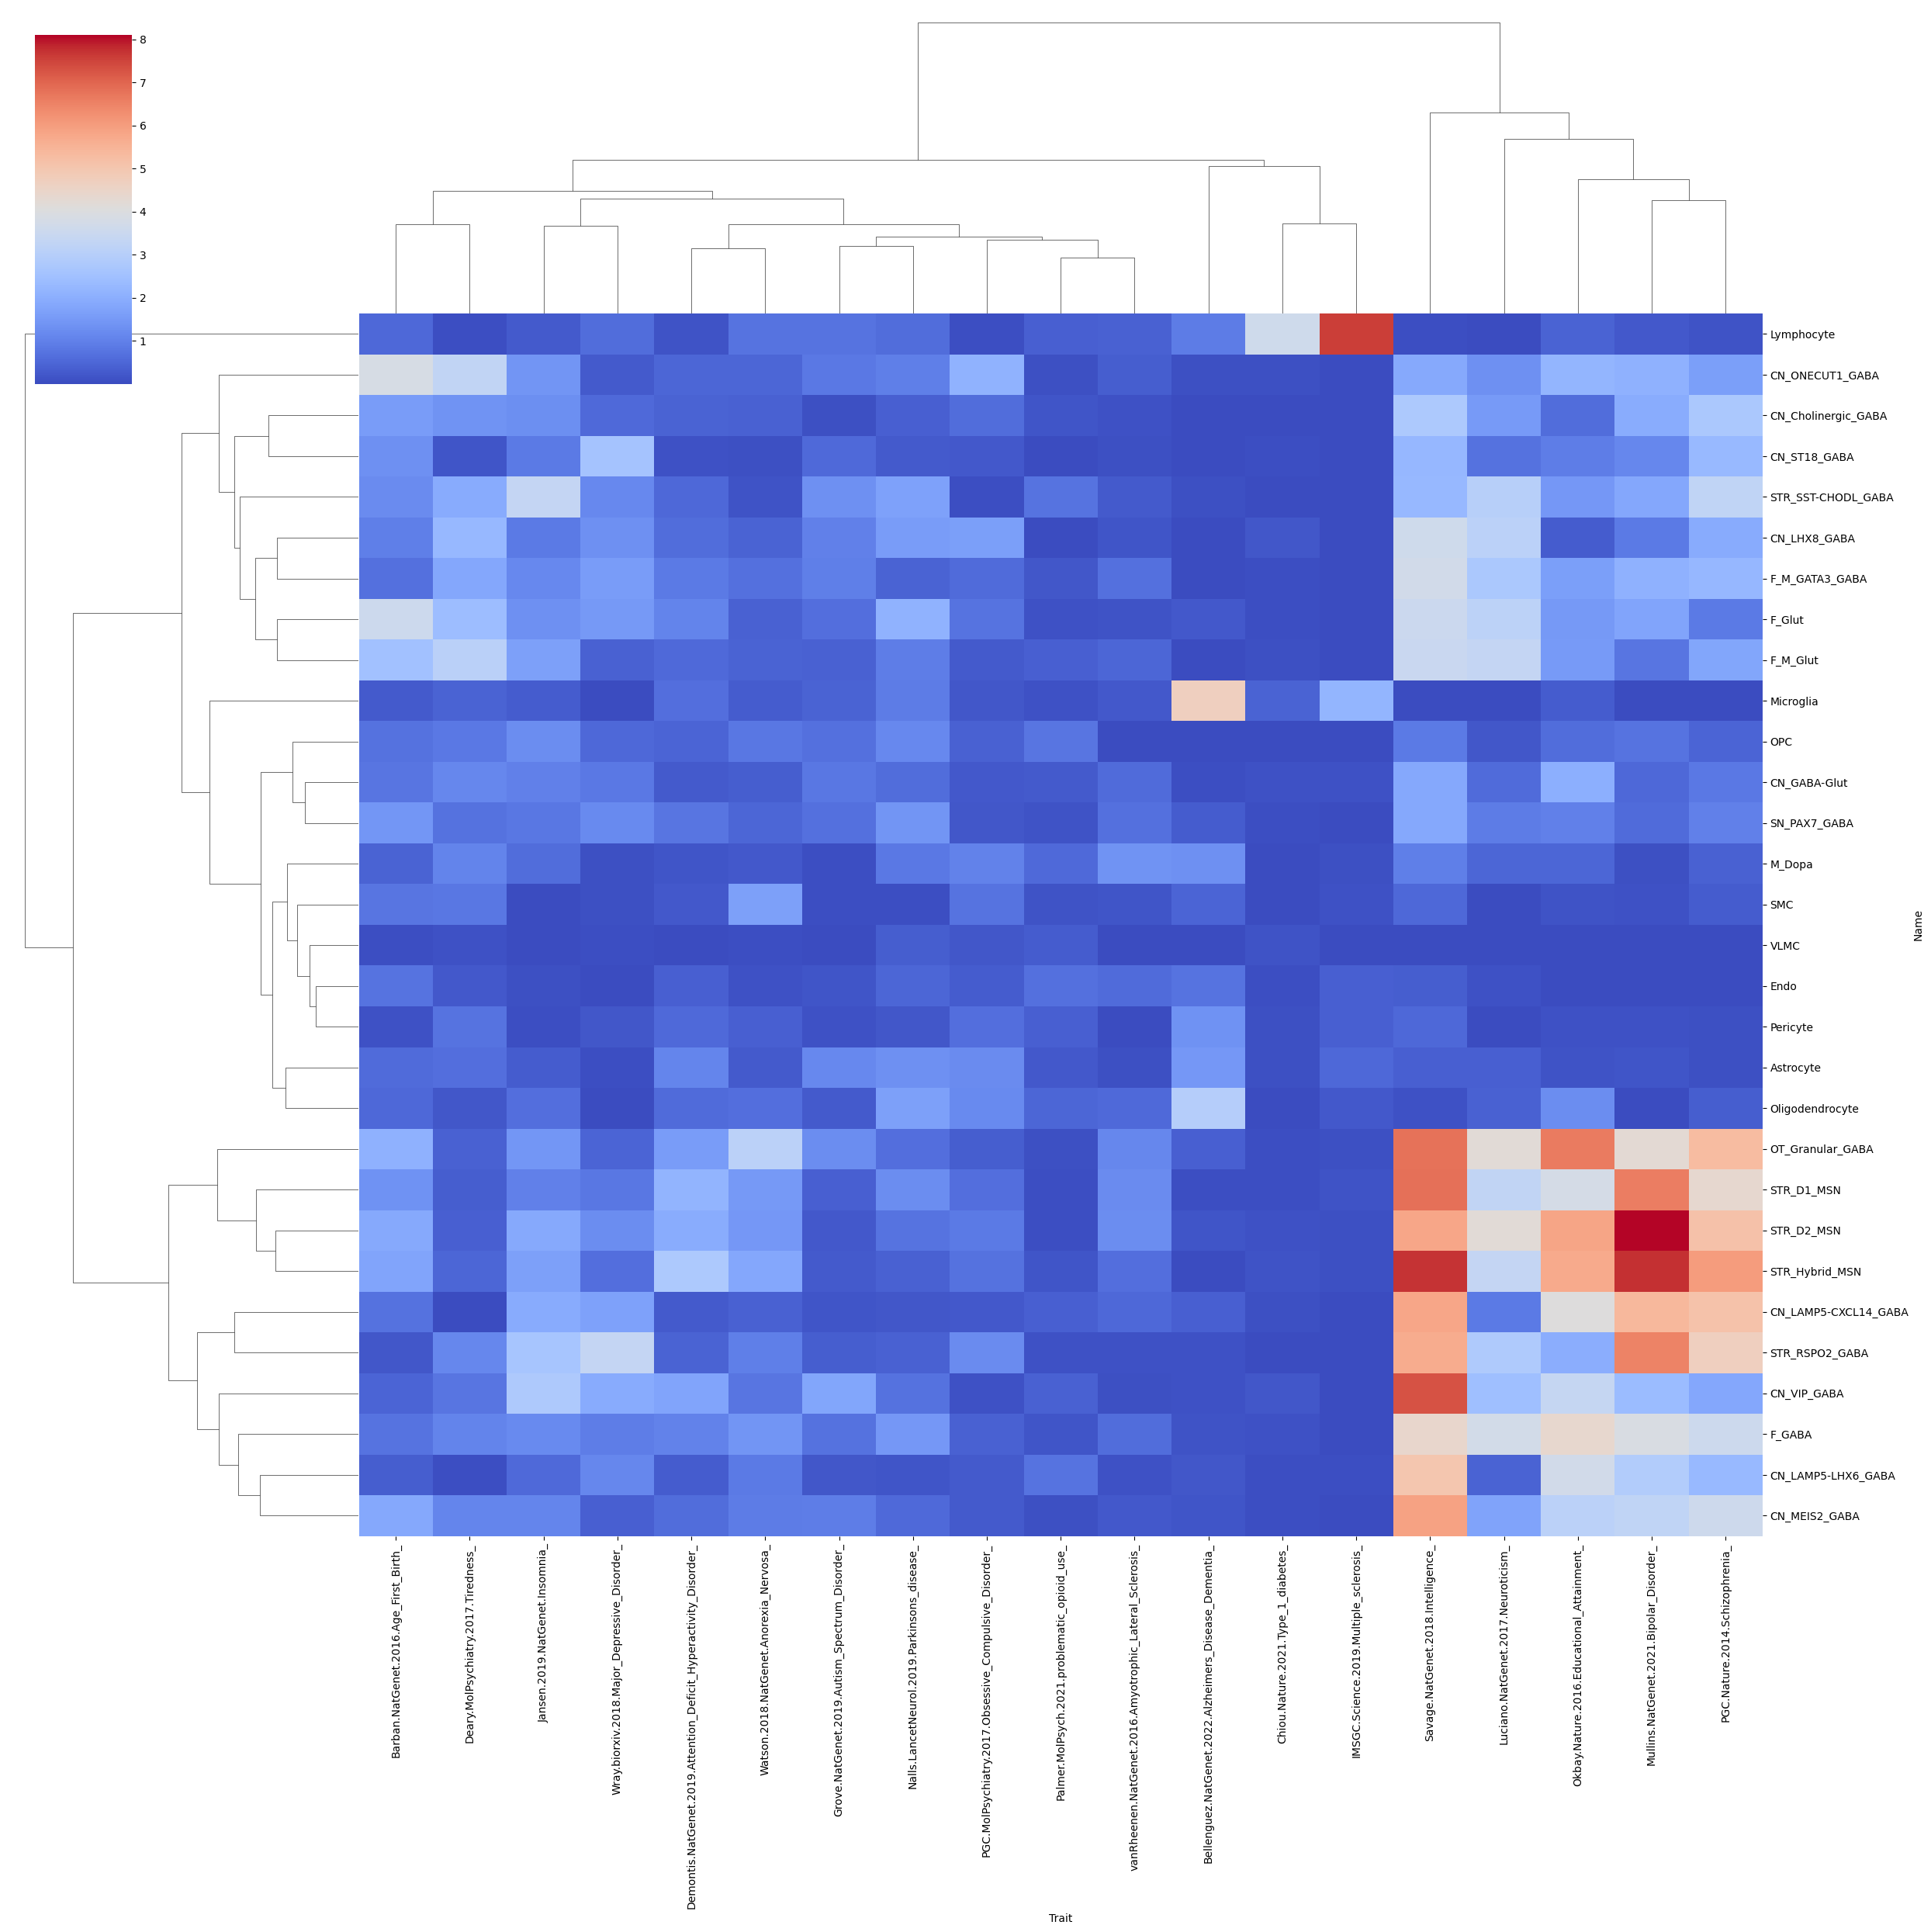

In [14]:
g = sns.clustermap(modified_df, cmap='coolwarm', figsize=(25, 25))

plt.show()
g.savefig(f'output/{run_id}_filtered.pdf')

In [15]:
def pval_to_star(p):
    if p < 1e-7:
        return '***'
    elif p < 1e-5:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

In [16]:
# Cluster rows
linkage_rows = linkage(modified_df.values, method="average", metric="euclidean")
row_order = leaves_list(linkage_rows)

# Cluster columns
linkage_cols = linkage(modified_df.values.T, method="average", metric="euclidean")
col_order = leaves_list(linkage_cols)

modified_df = modified_df.iloc[row_order, col_order].rename(columns = selected_traits)
fdr_modified_df = fdr_modified_df.iloc[row_order, col_order].rename(columns = selected_traits)

In [17]:
fdr_modified_df = fdr_modified_df.reindex(
    index=modified_df.index,    # same row order as df
    columns=modified_df.columns # same column order as df
)

In [18]:
cols_to_keep = fdr_modified_df.loc[:, (fdr_modified_df < 0.05).any()].columns
cols_to_keep

Index(['Age at First Birth', 'Tiredness', 'Insomnia',
       'Major Depressive Disorder', 'ADHD', 'Anorexia Nervosa',
       'Alzheimers Disease and Dementia', 'Type 1 Diabetes',
       'Multiple Sclerosis', 'Intelligence', 'Neuroticism',
       'Educational Attainment', 'Bipolar Disorder', 'Schizophrenia'],
      dtype='object', name='Trait')

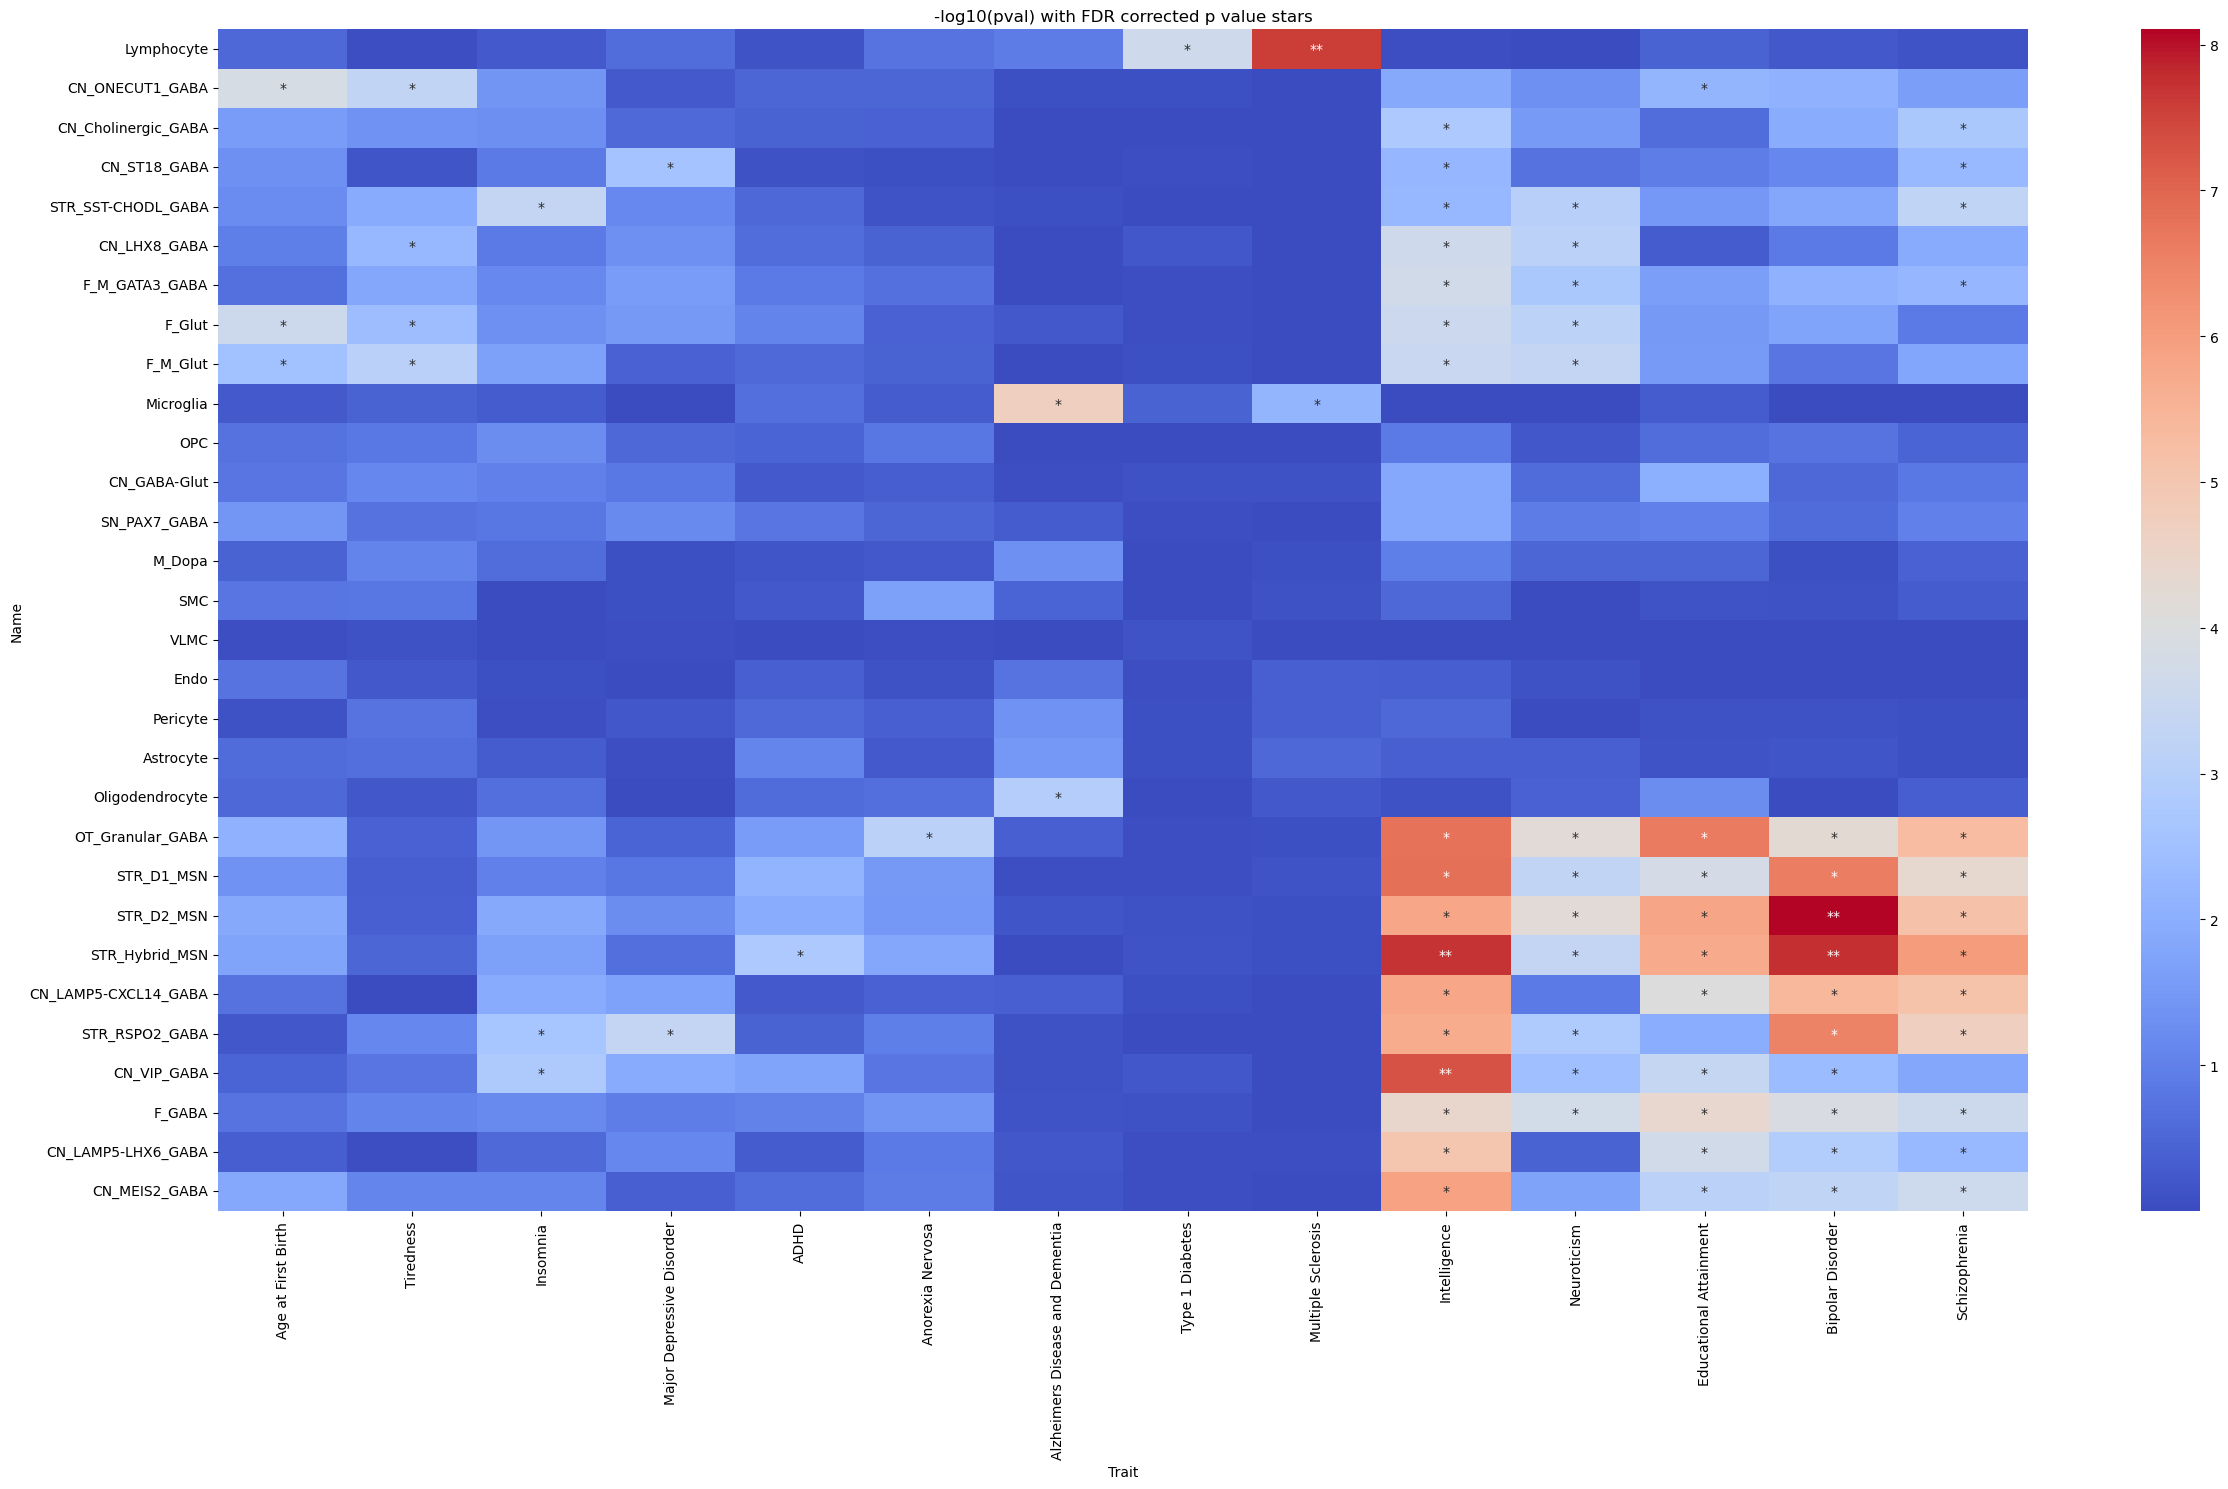

In [19]:
if len(cols_to_keep) > 0:
    stars = fdr_modified_df[cols_to_keep].applymap(pval_to_star)

    # Plot heatmap with annotations
    plt.figure(figsize=(25, 15))
    sns.heatmap(modified_df[cols_to_keep], annot=stars, fmt='', cmap='coolwarm')
    plt.title("-log10(pval) with FDR corrected p value stars")
    plt.tight_layout()
    plt.savefig(f'output/{run_id}_filtered_FDR_corrected.pdf')
    plt.show()
else:
    # Plot heatmap with annotations
    plt.figure(figsize=(16, 8))
    sns.heatmap(modified_df, fmt='', cmap='coolwarm')
    plt.title("-log10(pval) with raw p value")
    plt.tight_layout()
    plt.savefig(f'output/{run_id}_filtered_raw_pval.pdf')
    plt.show()

In [20]:
import os
metadata = pd.read_csv(os.path.expanduser("/anvil/projects/x-mcb130189/Wubin/BG/clustering/100kb/annotations.tsv"),sep='\t',index_col=0)
keep_cells=metadata.loc[~ (metadata['Group'].isin(['doublet','Glut','Unk','Low quality cells']))].index.tolist() #,
metadata=metadata.loc[keep_cells]
df_cols = metadata.loc[:,['Subclass','Class','Neighborhood']].drop_duplicates().set_index('Subclass')
df_cols.sort_values(['Neighborhood','Class','Subclass'],inplace=True)
df_cols.head()

,Class,Neighborhood
Subclass,,
F Glut,F M Glut,Glut Sero Dopa
F M Glut,F M Glut,Glut Sero Dopa
M Dopa,M Dopa,Glut Sero Dopa
Astrocyte,Astro-Epen,Nonneuron
Lymphocyte,Immune,Nonneuron


In [21]:
import matplotlib as mpl
mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi']=300

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


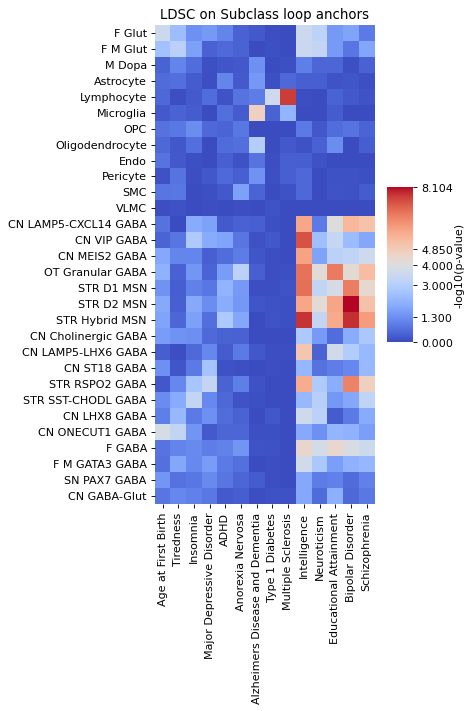

In [22]:
# Plot heatmap with annotations
import os

modified_df.index=modified_df.index.to_series().apply(lambda x:x.replace('_',' '))
fdr_modified_df.index=fdr_modified_df.index.to_series().apply(lambda x:x.replace('_',' '))

row_order=[ct for ct in df_cols.index.tolist() if ct in modified_df.index.tolist()]
vmax=modified_df.loc[row_order,cols_to_keep].max().max()

fig, ax = plt.subplots(figsize=(6, 9))
ax=sns.heatmap(modified_df.loc[row_order,cols_to_keep], #annot=fdr_modified_df.loc[row_order,cols_to_keep].applymap(pval_to_star), 
               fmt='', cmap='coolwarm',cbar_kws={'shrink': 0.4,'fraction':0.1,'aspect':6},
               annot_kws=dict(ha='center',va='center'),#vmin=0,vmax=4.85,cbar=False
              ax=ax)
# plt.title("-log10(pval) with FDR corrected p value stars")
ax.set_title("LDSC on Subclass loop anchors")
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
cbar = ax.collections[0].colorbar
cbar.set_label("-log10(p-value)", fontsize=10, labelpad=1)
cbar.set_ticks([0,1.3,3,4,4.85,vmax])
plt.tight_layout()
plt.savefig(f'{run_id}_fig.pdf')
# plt.savefig(os.path.expanduser("~/Projects/BG/pseudobulk/DMR/LDSC_plots/Group_loops.pdf"),transparent=True,bbox_inches='tight',dpi=300)
plt.show()